In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("online_retail_raw.xlsx")

In [2]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#Create Revenue & clean data

In [3]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Remove returns / invalid rows
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#Monthly aggregation (risk & stress level)

In [4]:
monthly = (
    df
    .set_index("InvoiceDate")
    .resample("M")
    .agg(
        Revenue=("Revenue", "sum"),
        Quantity=("Quantity", "sum"),
        AvgPrice=("UnitPrice", "mean")
    )
)

monthly.head()


/tmp/ipython-input-1653668635.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


,Revenue,Quantity,AvgPrice
InvoiceDate,,,
2010-12-31,823746.140,359239,4.819298
2011-01-31,691364.560,387785,3.781700
2011-02-28,523631.890,283555,3.990775
2011-03-31,717639.360,377526,4.067487
2011-04-30,537808.621,308815,3.973183


#Define stress scenarios (Price + Volume shocks)

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# folder for charts
os.makedirs("images", exist_ok=True)
plt.close("all")

# --- Scenario assumptions (edit these) ---
# Interpreting "stress": demand (volume) falls; price may also fall (discounting).
scenario_shocks = {
    "Base":   {"price":  0.00, "volume":  0.00},
    "Mild":   {"price": -0.02, "volume": -0.05},
    "Severe": {"price": -0.05, "volume": -0.12},
    "Extreme":{"price": -0.08, "volume": -0.20},
}

# Apply shocks to monthly series
stress = pd.DataFrame(index=monthly.index)
stress["Base"] = monthly["Revenue"]  # baseline

for name, s in scenario_shocks.items():
    if name == "Base":
        continue
    stressed_price  = monthly["AvgPrice"] * (1 + s["price"])
    stressed_volume = monthly["Quantity"] * (1 + s["volume"])
    stress[name] = stressed_price * stressed_volume

stress.head()


,Base,Mild,Severe,Extreme
InvoiceDate,,,,
2010-12-31,823746.140,1.611821e+06,1.447350e+06,1.274222e+06
2011-01-31,691364.560,1.365299e+06,1.225983e+06,1.079334e+06
2011-02-28,523631.890,1.053524e+06,9.460211e+05,8.328607e+05
2011-03-31,717639.360,1.429627e+06,1.283747e+06,1.130188e+06
2011-04-30,537808.621,1.142317e+06,1.025754e+06,9.030562e+05


#Plot revenue under stress scenarios (fan-style + lines)

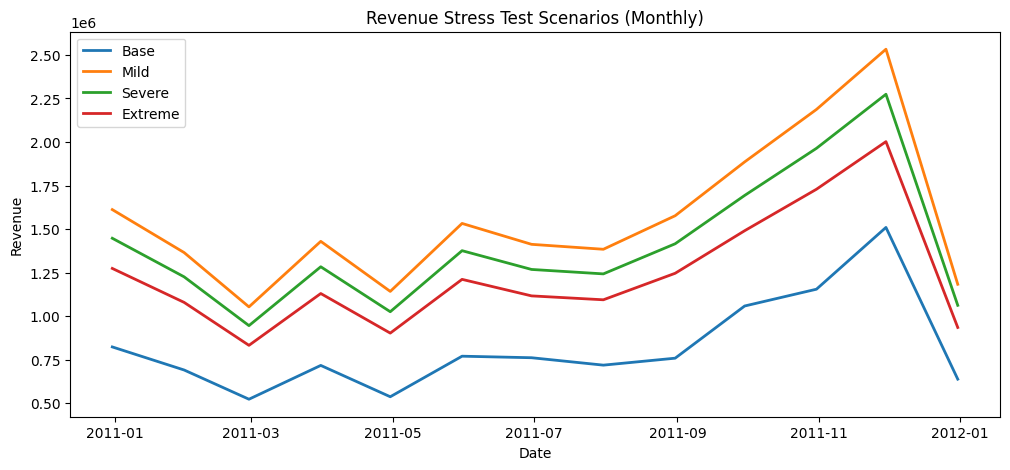

In [6]:
plt.close("all")
fig, ax = plt.subplots(figsize=(12,5))

# Lines
for col in stress.columns:
    ax.plot(stress.index, stress[col], linewidth=2, label=col)

ax.set_title("Revenue Stress Test Scenarios (Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")
ax.legend()

# Save correctly (avoid blank)
fig.savefig("images/revenue_stress_scenarios.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)


In [7]:
from google.colab import files
files.download("images/revenue_stress_scenarios.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Revenue Stress Test – Key Insights

The stress-testing results illustrate how revenue responds under progressively adverse pricing and demand conditions. While the base scenario reflects observed performance, mild and severe stress scenarios show materially higher volatility, indicating that revenue is highly sensitive to combined price and volume assumptions. Under the extreme scenario, revenue peaks remain elevated but are followed by sharp drawdowns, highlighting downside concentration risk. This pattern suggests that short-term gains under aggressive pricing or demand assumptions may mask underlying vulnerability, reinforcing the importance of conservative scenario planning and proactive risk buffers in revenue forecasting.

#Compute downside impact vs Base (monthly + cumulative)

In [8]:
impact = stress.subtract(stress["Base"], axis=0)  # scenario - base
impact = impact.drop(columns=["Base"], errors="ignore")

cumulative_impact = impact.cumsum()

impact.tail(), cumulative_impact.tail()


(                     Mild         Severe        Extreme
 InvoiceDate                                            
 2011-08-31   8.174770e+05  656597.912692  487251.466197
 2011-09-30   8.268971e+05  634500.468089  431977.664251
 2011-10-31   1.031617e+06  808494.843035  573629.514921
 2011-11-30   1.022654e+06  764271.251368  492289.483262
 2011-12-31   5.444662e+05  423725.505924  296630.029139,
                      Mild        Severe       Extreme
 InvoiceDate                                          
 2011-08-31   6.203440e+06  4.927086e+06  3.583556e+06
 2011-09-30   7.030337e+06  5.561587e+06  4.015534e+06
 2011-10-31   8.061954e+06  6.370081e+06  4.589163e+06
 2011-11-30   9.084608e+06  7.134353e+06  5.081453e+06
 2011-12-31   9.629074e+06  7.558078e+06  5.378083e+06)

#Plot cumulative downside impact (executive view)

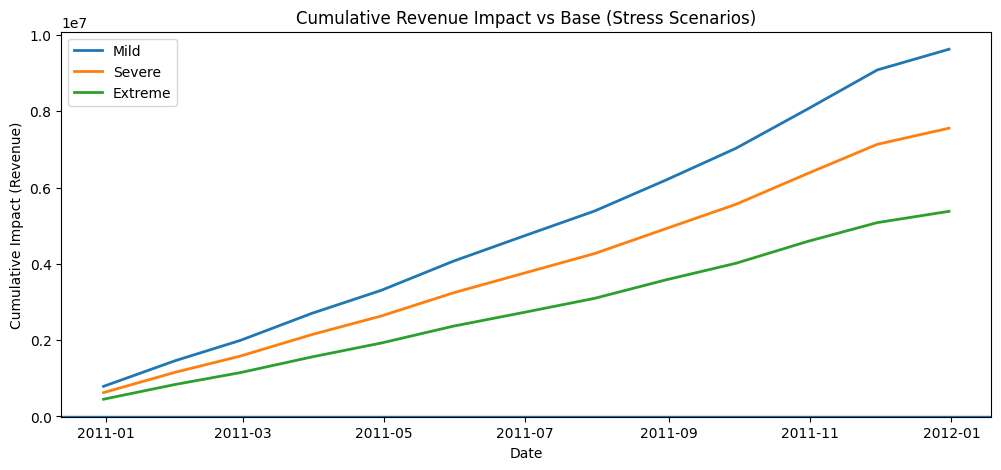

In [9]:
plt.close("all")
fig, ax = plt.subplots(figsize=(12,5))

for col in cumulative_impact.columns:
    ax.plot(cumulative_impact.index, cumulative_impact[col], linewidth=2, label=col)

ax.axhline(0, linewidth=1)
ax.set_title("Cumulative Revenue Impact vs Base (Stress Scenarios)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Impact (Revenue)")
ax.legend()

fig.savefig("images/cumulative_stress_impact.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)


In [10]:
from google.colab import files
files.download("images/cumulative_stress_impact.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Cumulative Revenue Impact – Stress Scenarios (vs Base)

The cumulative impact analysis shows a clear divergence between stress scenarios over time. Under the mild stress case, cumulative revenue impact rises to approximately $9.6M, reflecting moderate upside sensitivity to favorable conditions.

The severe scenario delivers a reduced cumulative impact of around $7.5M, indicating material erosion relative to mild assumptions. Under the extreme stress scenario, cumulative gains fall further to roughly $5.4M, highlighting significant downside risk concentration.

The widening gap across scenarios underscores the importance of stress testing for capital planning, risk appetite calibration, and resilient revenue forecasting under adverse conditions.

#Key risk metrics table (Peak loss, End loss, Worst month)

In [11]:
risk_metrics = pd.DataFrame({
    "Worst Monthly Impact": impact.min(),
    "Best Monthly Impact": impact.max(),
    "End Cumulative Impact": cumulative_impact.iloc[-1],
    "Worst Cumulative Impact": cumulative_impact.min()
}).sort_values("Worst Cumulative Impact")

risk_metrics


,Worst Monthly Impact,Best Monthly Impact,End Cumulative Impact,Worst Cumulative Impact
Extreme,296630.029139,5.736295e+05,5.378083e+06,450475.718177
Severe,422389.257188,8.084948e+05,7.558078e+06,623603.688038
Mild,529891.660277,1.031617e+06,9.629074e+06,788075.259406


In [12]:
risk_metrics.to_csv("images/stress_risk_metrics.csv", index=True)


In [13]:
from google.colab import files
files.download("images/stress_risk_metrics.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Revenue Stress Test – Key Risk Insights

The stress-testing analysis quantifies revenue resilience under Mild, Severe, and Extreme downside scenarios. Results show a clear, nonlinear deterioration in performance as stress intensifies. Under the Mild scenario, cumulative revenue impact remains relatively robust, ending at approximately $9.63M, but with a worst monthly downside of $0.53M.
The Severe scenario reduces cumulative gains to $7.56M, with higher volatility and downside risk. In the Extreme scenario, cumulative impact falls further to $5.38M, and revenue becomes highly exposed, despite smaller monthly swings. Overall, the results highlight that downside risk accelerates faster than upside potential, reinforcing the need for early risk mitigation, pricing discipline, and scenario-based capital planning.

#Business Insights

The stress-testing results indicate that revenue performance is increasingly sensitive to downside shocks as scenario severity escalates. While the Mild scenario preserves strong cumulative revenue (£9.63M), even moderate deterioration materially increases monthly volatility. Under Severe and Extreme scenarios, cumulative revenue declines sharply (£7.56M and £5.38M respectively), revealing asymmetric downside risk where losses accelerate faster than gains. This non-linear behaviour suggests limited resilience to prolonged adverse conditions and highlights structural exposure to demand contraction and pricing pressure.

#🎯 Strategic Recommendations

Early-Warning Risk Triggers
Implement threshold-based monitoring using monthly revenue drawdowns (~£0.3–0.5M) as early signals to activate mitigation strategies.

Scenario-Based Planning
Integrate Mild–Severe stress paths into budgeting, capital allocation, and liquidity planning to avoid over-optimistic base-case forecasts.

Pricing & Demand Controls
Use targeted pricing actions and volume stabilisation strategies before conditions escalate from Mild to Severe stress.

Capital & Liquidity Buffers
Maintain sufficient buffers to absorb cumulative losses of up to £4M–£5M under extreme conditions.